## Imports



In [91]:
import pandas as pd
import numpy as np
import urllib
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Tratamento

#### 2019

In [193]:
chunksize = 10000
chunks = pd.read_csv(
    'MICRODADOS_ENEM_2019.csv',
    chunksize=chunksize,
    on_bad_lines='skip',
    encoding='latin1',
    delimiter=";"
)

df_raw = pd.concat(chunks)

In [195]:
colunas_interesse = [
    'NU_INSCRICAO', 'TP_SEXO', 'TP_COR_RACA', 'SG_UF_ESC', 
    'TP_ESCOLA', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 
    'TP_STATUS_REDACAO',
    'Q001', 'Q002', 'Q003', 'Q006', 'Q024', 'Q025', 'SG_UF_PROVA', 
    'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC',
]

In [196]:
df = df_raw[colunas_interesse]
df['MUNICIPIO'] = np.where(
    df['NO_MUNICIPIO_ESC'].isna() | (df['NO_MUNICIPIO_ESC'] == ""),
    df['NO_MUNICIPIO_PROVA'],
    df['NO_MUNICIPIO_ESC']
)


df['UF'] = np.where(
    df['SG_UF_ESC'].isna() | (df['SG_UF_ESC'] == ""),
    df['SG_UF_PROVA'],
    df['SG_UF_ESC']
)


C:\Users\139595\AppData\Local\Temp\ipykernel_26388\2123437484.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\139595\AppData\Local\Temp\ipykernel_26388\2123437484.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [197]:
df = df[
  (df['UF'] == 'CE')
   ]

In [198]:
df['Tem_Computador'] = np.where(df['Q024'] == 'A', 0, 1) 
df['Tem_Internet'] = np.where(df['Q025'] == 'A', 0, 1) 
df['Alta_Estrutura'] = np.where(df['TP_DEPENDENCIA_ADM_ESC'].isin([1,4]), 1, 0)
df['Inclusao_Digital_Plena'] = df['Tem_Computador'] * df['Tem_Internet']
df['Tipo_Escola'] = np.where(df['TP_DEPENDENCIA_ADM_ESC'].isin([2,3]), 'Baixa Estrutura',
                              np.where(df['TP_DEPENDENCIA_ADM_ESC'].isin([1,4]), 'Alta Estrutura', 'Outro'))
df['NU_NOTA_GERAL'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT'] + df['NU_NOTA_REDACAO']) / 5
# df = df.dropna(subset=['NU_NOTA_GERAL'])

In [199]:
print(len(df))
df = df[
  (df['TP_PRESENCA_CH'] * df['TP_PRESENCA_LC'] * df['TP_PRESENCA_CN'] * df['TP_PRESENCA_MT']) == 1 
]
print(len(df))


295448
221655


(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'Especializado'),
  Text(2, 0, 'Indústria'),
  Text(3, 0, 'Rural'),
  Text(4, 0, 'Sem info'),
  Text(5, 0, 'Serviços Gerais'),
  Text(6, 0, 'Técnico/Autônomo')])

<Figure size 1200x600 with 0 Axes>

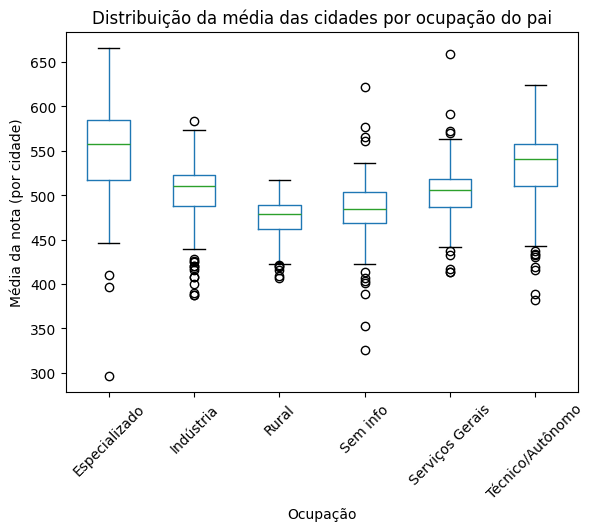

In [158]:
df_cidade = (
    df.groupby(['MUNICIPIO', 'Q003'], as_index=False)
      .agg(media_cidade=('NU_NOTA_GERAL', 'mean'))
)

df_cidade["Q003"] = df_cidade["Q003"].replace({
    "A" : "Rural",
    "B" : "Serviços Gerais" ,
    "C" : "Indústria",
    "D" : "Técnico/Autônomo",
    "E" : "Especializado",
    "F" : "Sem info"
})

plt.figure(figsize=(12, 6))

df_cidade.boxplot(
    column='media_cidade',
    by='Q003',
    grid=False
)

plt.title('Distribuição da média das cidades por ocupação do pai')
plt.suptitle('')
plt.xlabel('Ocupação')
plt.ylabel('Média da nota (por cidade)')
plt.xticks(rotation=45)


In [200]:
df_indicadores_mun = df.groupby('MUNICIPIO').agg(
    Total_Alunos=('Inclusao_Digital_Plena', 'count'),
    Total_Inclusao_Digital=('Inclusao_Digital_Plena', 'sum'),
    Taxa_Inclusao_Digital=('Inclusao_Digital_Plena', 'mean'),
    Internet =('Tem_Internet', 'sum'),
    Taxa_Internet=('Tem_Internet', 'mean'),
    Computador =('Tem_Computador', 'sum'),
    Taxa_Computador=('Tem_Computador', 'mean'),
    Nota_Redacao=('NU_NOTA_REDACAO', 'mean'),
    Nota_CH=('NU_NOTA_CH', 'mean'),
    Nota_Mat=('NU_NOTA_MT', 'mean'),
    Nota_LC=('NU_NOTA_LC', 'mean'),
    Nota_CN=('NU_NOTA_CN', 'mean'),
    Nota_Media_Geral=('NU_NOTA_GERAL', 'mean'),
    Baixa_Estrutura=('Tipo_Escola', lambda x: (x == 'Baixa Estrutura').sum()),
    Alta_Estrutura=('Tipo_Escola', lambda x: (x == 'Alta Estrutura').sum()),
    # Renda_Baixa=('renda_familiar', lambda x: (x == 'Renda Baixa').sum()),
    # Renda_Media=('renda_familiar', lambda x: (x == 'Renda Média').sum()),
    # Renda_Alta=('renda_familiar', lambda x: (x == 'Renda Alta').sum())
).reset_index()


df_indicadores_mun['Taxa_Alunos'] = df_indicadores_mun['Total_Alunos'] / df_indicadores_mun['Total_Alunos'].sum()

In [201]:
ideb = pd.read_excel('divulgacao_ensino_medio_escolas_2023.xlsx', sheet_name='Planilha3', header=2)
ideb = ideb.rename(columns={'Rótulos de Linha': 'MUNICIPIO'})
df_indicadores_mun = df_indicadores_mun.merge(ideb[['MUNICIPIO', 'SAEB19']], on="MUNICIPIO", how='left')
df_indicadores_mun
df_indicadores_mun['z_score_nota'] = (df_indicadores_mun['Nota_Media_Geral'] - df_indicadores_mun['Nota_Media_Geral'].mean()) / df_indicadores_mun['Nota_Media_Geral'].std()
df_indicadores_mun['z_score_IDEB19'] = (df_indicadores_mun['SAEB19'] - df_indicadores_mun['SAEB19'].mean()) / df_indicadores_mun['SAEB19'].std()



#### 2024

In [194]:
# chunksize = 10000
# chunks = pd.read_csv(
#     'RESULTADOS_2023.csv',
#     chunksize=chunksize,
#     on_bad_lines='skip',
#     encoding='latin1',
#     delimiter=";"
# )

chunksize = 10000
chunks = pd.read_csv(
    'MICRODADOS_ENEM_2023.csv',
    chunksize=chunksize,
    on_bad_lines='skip',
    encoding='latin1',
    delimiter=";"
)



# alunos23 = pd.concat(chunks)
df23 = pd.concat(chunks)

In [202]:
df23['MUNICIPIO'] = np.where(
    df23['NO_MUNICIPIO_ESC'].isna() | (df23['NO_MUNICIPIO_ESC'] == ""),
    df23['NO_MUNICIPIO_PROVA'],
    df23['NO_MUNICIPIO_ESC']
)

df23['UF'] = np.where(
    df23['SG_UF_ESC'].isna() | (df23['SG_UF_ESC'] == ""),
    df23['SG_UF_PROVA'],
    df23['SG_UF_ESC']
)

In [203]:
# alunos23 = alunos23[alunos23['SG_UF_PROVA'] == 'CE']
df23 = df23[df23['UF'] == 'CE']
# alunos23 = alunos23.rename(columns={'Q020': 'Internet', 'Q021': 'Computador'})
df23 = df23.rename(columns={'Q025': 'Internet', 'Q024': 'Computador'})
# df23['Alta_Estrutura'] = np.where(df23['TP_DEPENDENCIA_ADM_ESC'].isin([1,4]), 1, 0)
# alunos23['Tem_Computador'] = np.where(alunos23['Computador'] == 'A', 0, 1) 
# alunos23['Tem_Internet'] = np.where(alunos23['Internet'] == 'A', 0, 1) 
# alunos23['Inclusao_Digital_Plena'] = alunos23['Tem_Computador'] * alunos23['Tem_Internet']
df23['Tem_Computador'] = np.where(df23['Computador'] == 'A', 0, 1) 
df23['Tem_Internet'] = np.where(df23['Internet'] == 'A', 0, 1) 
df23['Inclusao_Digital_Plena'] = df23['Tem_Computador'] * df23['Tem_Internet']

df23['Nota_Media_Geral'] = (df23['NU_NOTA_CH'] + df23['NU_NOTA_CN'] + df23['NU_NOTA_LC']  + df23['NU_NOTA_MT'] + df23['NU_NOTA_REDACAO']) / 5

df23['Tipo_Escola'] = np.where(df23['TP_DEPENDENCIA_ADM_ESC'].isin([2,3]), 'Baixa Estrutura',
                              np.where(df23['TP_DEPENDENCIA_ADM_ESC'].isin([1,4]), 'Alta Estrutura', 'Outro'))

# df23 = df23.dropna(subset=['Nota_Media_Geral'])

In [204]:
df_indicadores_mun23 = df23.groupby('MUNICIPIO').agg(
    Nota_Redacao=('NU_NOTA_REDACAO', 'mean'),
    Nota_CH=('NU_NOTA_CH', 'mean'),
    Nota_Mat=('NU_NOTA_MT', 'mean'),
    Nota_LC=('NU_NOTA_LC', 'mean'),
    Nota_CN=('NU_NOTA_CN', 'mean'),
    Nota_Media_Geral=('Nota_Media_Geral', 'mean'),
    Total_Inclusao_Digital=('Inclusao_Digital_Plena', 'sum'),
    Taxa_Inclusao_Digital=('Inclusao_Digital_Plena', 'mean'),
    Internet =('Tem_Internet', 'sum'),
    Taxa_Internet=('Tem_Internet', 'mean'),
    Computador =('Tem_Computador', 'sum'),
    Taxa_Computador=('Tem_Computador', 'mean'),
    Total_Alunos=('NU_INSCRICAO', 'count'),
    Baixa_Estrutura=('Tipo_Escola', lambda x: (x == 'Baixa Estrutura').sum()),
    Alta_Estrutura=('Tipo_Escola', lambda x: (x == 'Alta Estrutura').sum()),
    # Renda_Baixa=('renda_familiar', lambda x: (x == 'Renda Baixa').sum()),
    # Renda_Media=('renda_familiar', lambda x: (x == 'Renda Média').sum()),
    # Renda_Alta=('renda_familiar', lambda x: (x == 'Renda Alta').sum())
    
)

df_indicadores_mun23['Taxa_Alunos'] = df_indicadores_mun23['Total_Alunos'] / df_indicadores_mun23['Total_Alunos'].sum()
df_indicadores_mun23 = df_indicadores_mun23.sort_values(by=['Taxa_Inclusao_Digital'], ascending=False).reset_index()
# faça para df_indicadores_mun23 agora:
df_indicadores_mun23 = df_indicadores_mun23.merge(ideb[['MUNICIPIO', 'SAEB23']], on="MUNICIPIO", how='left')
df_indicadores_mun23
df_indicadores_mun23['z_score_nota'] = (df_indicadores_mun23['Nota_Media_Geral'] - df_indicadores_mun23['Nota_Media_Geral'].mean()) / df_indicadores_mun23['Nota_Media_Geral'].std()
df_indicadores_mun23['z_score_IDEB23'] = (df_indicadores_mun23['SAEB23'] - df_indicadores_mun23['SAEB23'].mean()) / df_indicadores_mun23['SAEB23'].std()

## IDEB

In [ ]:
df_indicadores_mun['SAEB19']

In [192]:
#correlaçao 2019
display(df_indicadores_mun[['Nota_Media_Geral', 'SAEB19']].corr())
display(df_indicadores_mun23[['Nota_Media_Geral', 'SAEB23']].corr())

print(df_indicadores_mun['SAEB19'].mean())
print(df_indicadores_mun['Nota_Media_Geral'].mean())
print(df_indicadores_mun23['SAEB23'].mean())
print(df_indicadores_mun23['Nota_Media_Geral'].mean())

,Nota_Media_Geral,SAEB19
Nota_Media_Geral,1.000000,0.531342
SAEB19,0.531342,1.000000


,Nota_Media_Geral,SAEB23
Nota_Media_Geral,1.000000,0.308344
SAEB23,0.308344,1.000000


4.393331147227001
483.88424608433127
4.549605692486758
495.46615486128024


In [167]:
total_alunos = df_indicadores_mun['Total_Alunos'].sum()
total_inclusao = df_indicadores_mun['Total_Inclusao_Digital'].sum()
total_internet =  df_indicadores_mun['Internet'].sum()
total_comp =  df_indicadores_mun['Computador'].sum()

print(f"Total de Alunos presentes: {total_alunos}")
print(f"Total com Inclusão Digital Plena: {total_inclusao}")
print(f"Total com Internet: {total_internet}")
print(f"Total com Computador(es): {total_comp}")


Total de Alunos presentes: 221655
Total com Inclusão Digital Plena: 79032
Total com Internet: 151605
Total com Computador(es): 83359


In [168]:
total_alunos = df_indicadores_mun23['Total_Alunos'].sum()
total_inclusao = df_indicadores_mun23['Total_Inclusao_Digital'].sum()
total_internet =  df_indicadores_mun23['Internet'].sum()
total_comp =  df_indicadores_mun23['Computador'].sum()

print(f"Total de Alunos: {total_alunos}")
print(f"Total com Inclusão Digital Plena: {total_inclusao}")
print(f"Total com Internet: {total_internet}")
print(f"Total com Computador(es): {total_comp}")

Total de Alunos: 242421
Total com Inclusão Digital Plena: 71609
Total com Internet: 207689
Total com Computador(es): 72673


In [89]:
df_indicadores_mun23

,MUNICIPIO,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Total_Alunos,Baixa_Estrutura,Alta_Estrutura,Renda_Baixa,Renda_Média,Renda_Alta,Taxa_Alunos,SAEB23,z_score_nota,z_score_IDEB23
0,Fortaleza,652.884172,537.033357,559.518961,530.382698,507.469060,560.222569,32283,0.434063,66281,0.891185,32646,0.438944,74374,21807,5827,0,0,0,0.306797,4.398026,2.122844,-0.354518
1,Eusébio,638.696343,525.409459,547.209304,523.016693,493.617016,550.103269,780,0.420032,1790,0.963920,788,0.424340,1857,805,46,0,0,0,0.007660,4.700000,1.791113,0.351747
2,Juazeiro do Norte,657.386505,526.989844,547.848146,521.031420,500.777275,553.422521,4033,0.405286,9068,0.911265,4088,0.410813,9951,2590,471,0,0,0,0.041048,4.725000,1.899925,0.410218
3,Limoeiro do Norte,673.108808,525.486917,550.956789,521.789184,498.480334,556.859531,811,0.398526,1881,0.924324,822,0.403931,2035,356,158,0,0,0,0.008394,4.850000,2.012597,0.702571
4,Sobral,653.237485,523.077377,557.019438,516.119470,496.983512,552.325793,2953,0.388604,7023,0.924201,2976,0.391630,7599,2294,487,0,0,0,0.031346,5.047059,1.863972,1.163459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Catunda,449.577465,444.388732,440.726087,449.971831,417.565217,441.373333,2,0.021739,86,0.934783,2,0.021739,92,92,0,0,0,0,0.000380,4.500000,-1.773270,-0.116019
180,Miraíma,421.257143,437.051429,436.858824,447.128571,416.631176,434.467219,3,0.015075,195,0.979899,3,0.015075,199,199,0,0,0,0,0.000821,4.150000,-1.999666,-0.934610
181,Arneiroz,408.955224,461.120896,462.463492,458.667164,447.988889,452.694194,1,0.010870,77,0.836957,1,0.010870,92,92,0,0,0,0,0.000380,4.300000,-1.402150,-0.583785
182,Catarina,360.923077,430.516923,462.696825,445.923077,426.971429,430.420645,0,0.000000,100,1.000000,0,0.000000,100,100,0,0,0,0,0.000413,4.200000,-2.132321,-0.817668


In [90]:
display(df_indicadores_mun23[['Nota_Media_Geral', 'Taxa_Computador', 'Taxa_Internet', 'Taxa_Inclusao_Digital']].corr().sort_values(by=['Nota_Media_Geral'], ascending=False))

,Nota_Media_Geral,Taxa_Computador,Taxa_Internet,Taxa_Inclusao_Digital
Nota_Media_Geral,1.000000,0.807865,0.157791,0.809091
Taxa_Inclusao_Digital,0.809091,0.996637,0.279449,1.000000
Taxa_Computador,0.807865,1.000000,0.260294,0.996637
Taxa_Internet,0.157791,0.260294,1.000000,0.279449


In [142]:
df_indicadores_mun23

,MUNICIPIO,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Total_Alunos,Baixa_Estrutura,Alta_Estrutura,Renda_Baixa,Renda_Média,Renda_Alta,Taxa_Alunos,SAEB23,z_score_nota,z_score_IDEB23
0,Fortaleza,652.884172,537.033357,559.518961,530.382698,507.469060,560.222569,32283,0.434063,66281,0.891185,32646,0.438944,74374,21807,5827,58777,10422,5175,0.306797,4.398026,2.122844,-0.354518
1,Eusébio,638.696343,525.409459,547.209304,523.016693,493.617016,550.103269,780,0.420032,1790,0.963920,788,0.424340,1857,805,46,1420,269,168,0.007660,4.700000,1.791113,0.351747
2,Juazeiro do Norte,657.386505,526.989844,547.848146,521.031420,500.777275,553.422521,4033,0.405286,9068,0.911265,4088,0.410813,9951,2590,471,8596,1065,290,0.041048,4.725000,1.899925,0.410218
3,Limoeiro do Norte,673.108808,525.486917,550.956789,521.789184,498.480334,556.859531,811,0.398526,1881,0.924324,822,0.403931,2035,356,158,1778,227,30,0.008394,4.850000,2.012597,0.702571
4,Sobral,653.237485,523.077377,557.019438,516.119470,496.983512,552.325793,2953,0.388604,7023,0.924201,2976,0.391630,7599,2294,487,6492,891,216,0.031346,5.047059,1.863972,1.163459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Catunda,449.577465,444.388732,440.726087,449.971831,417.565217,441.373333,2,0.021739,86,0.934783,2,0.021739,92,92,0,92,0,0,0.000380,4.500000,-1.773270,-0.116019
180,Miraíma,421.257143,437.051429,436.858824,447.128571,416.631176,434.467219,3,0.015075,195,0.979899,3,0.015075,199,199,0,199,0,0,0.000821,4.150000,-1.999666,-0.934610
181,Arneiroz,408.955224,461.120896,462.463492,458.667164,447.988889,452.694194,1,0.010870,77,0.836957,1,0.010870,92,92,0,92,0,0,0.000380,4.300000,-1.402150,-0.583785
182,Catarina,360.923077,430.516923,462.696825,445.923077,426.971429,430.420645,0,0.000000,100,1.000000,0,0.000000,100,100,0,100,0,0,0.000413,4.200000,-2.132321,-0.817668


In [191]:
df_indicadores_mun['z_score_IDEB19']

0     -0.235118
1     -0.235118
2      0.478650
3      1.276391
4     -0.738955
         ...   
179    0.100773
180   -0.990873
181   -0.235118
182    0.016800
183   -0.403064
Name: z_score_IDEB19, Length: 184, dtype: float64

In [205]:
df_indicadores_mun.to_csv('indicadores19.csv')
df_indicadores_mun23.to_csv('indicadores23.csv')

<Figure size 1200x600 with 0 Axes>

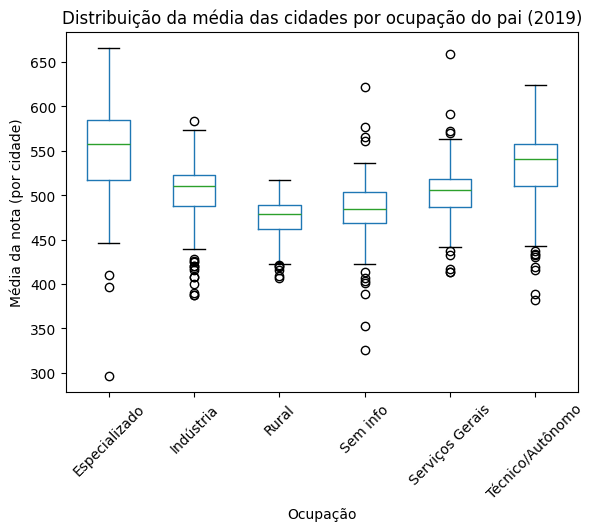

In [188]:
df_cidade = (
    df.groupby(['MUNICIPIO', 'Q003'], as_index=False)
      .agg(media_cidade=('NU_NOTA_GERAL', 'mean'))
)
df_cidade["Q003"] = df_cidade["Q003"].replace({
    "A" : "Rural",
    "B" : "Serviços Gerais" ,
    "C" : "Indústria",
    "D" : "Técnico/Autônomo",
    "E" : "Especializado",
    "F" : "Sem info"
})

plt.figure(figsize=(12, 6))

df_cidade.boxplot(
    column='media_cidade',
    by='Q003',
    grid=False
)

plt.title('Distribuição da média das cidades por ocupação do pai (2019)')
plt.suptitle('')
plt.xlabel('Ocupação')
plt.ylabel('Média da nota (por cidade)')
plt.xticks(rotation=45)

plt.show()

<Figure size 1200x600 with 0 Axes>

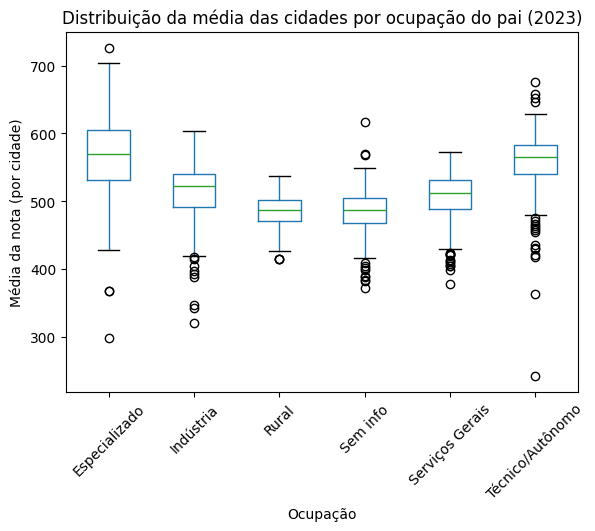

In [190]:
df_cidade = (
    df23.groupby(['MUNICIPIO', 'Q003'], as_index=False)
      .agg(media_cidade=('Nota_Media_Geral', 'mean'))
)
df_cidade["Q003"] = df_cidade["Q003"].replace({
    "A" : "Rural",
    "B" : "Serviços Gerais" ,
    "C" : "Indústria",
    "D" : "Técnico/Autônomo",
    "E" : "Especializado",
    "F" : "Sem info"
})

plt.figure(figsize=(12, 6))

df_cidade.boxplot(
    column='media_cidade',
    by='Q003',
    grid=False
)

plt.title('Distribuição da média das cidades por ocupação do pai (2023)')
plt.suptitle('')
plt.xlabel('Ocupação')
plt.ylabel('Média da nota (por cidade)')
plt.xticks(rotation=45)

plt.show()

C:\Users\139595\AppData\Local\Temp\ipykernel_26388\4281936371.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




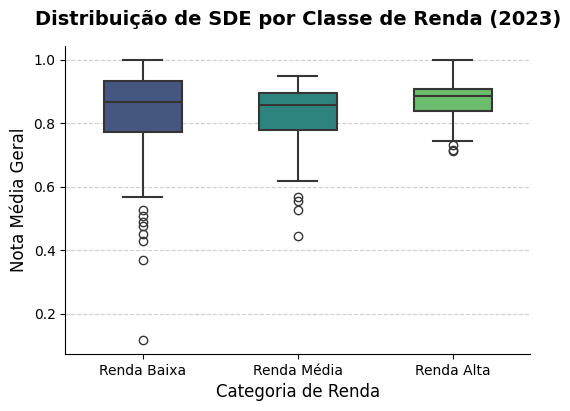

In [63]:
ordem_renda = ["Renda Baixa", "Renda Média", "Renda Alta"]

# 2. Criar a Figura e o Eixo (Axes)
fig, ax = plt.subplots(figsize=(6, 4))

# 3. Gerar o Boxplot
# A paleta "viridis" ou "Blues" é ótima para dar ideia de intensidade/progresso
sns.boxplot(
    data=df_indicadores_mun23,
    x="categoria_renda",
    y="Taxa_Internet",
    order=ordem_renda,    # Aplica a ordem correta
    palette="viridis",    # Cores bonitas e profissionais
    width=0.5,            # Largura das caixas para não ficarem "gordas" demais
    linewidth=1.5,        # Espessura das linhas
    ax=ax
)

# 4. Customizações Visuais (Deixar com cara de relatório)
ax.set_title("Distribuição de SDE por Classe de Renda (2023)", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Categoria de Renda", fontsize=12)
ax.set_ylabel("Nota Média Geral", fontsize=12)

# Adiciona um grid horizontal pontilhado (ajuda a ver a altura das medianas)
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

# Remove as bordas desnecessárias (topo e direita) para limpar o visual
sns.despine()

In [181]:
import plotly.express as px
import streamlit as st
import pandas as pd
import unicodedata

# --- FUNÇÃO AUXILIAR (CORREÇÃO DO ERRO) ---
def limpar_texto(texto):
    if pd.isna(texto): return ""
    # 1. Normaliza (separa o acento da letra visualmente)
    nfkd = unicodedata.normalize('NFKD', str(texto))
    # 2. Filtra: pega apenas o que NÃO é acento (combining character)
    texto_sem_acento = "".join([c for c in nfkd if not unicodedata.combining(c)])
    # 3. Retorna em Maiúsculo
    return texto_sem_acento.upper().strip()

def gerarMapaInterativo(df, coluna_valor, titulo):
    # Pega as coordenadas
    url = "https://raw.githubusercontent.com/kelvins/municipios-brasileiros/main/csv/municipios.csv"
    coord = pd.read_csv(url)
    coord = coord[coord["codigo_uf"] == 23][["nome", "longitude", "latitude"]]
    
    # --- AQUI ESTAVA O ERRO ---
    # Agora usamos a função auxiliar 'limpar_texto' em vez de chamar o módulo direto
    coord["chave"] = coord["nome"].apply(limpar_texto)
    
    # Criamos uma cópia do DF do usuário para não alterar o original fora da função
    df = df.copy()
    df["chave"] = df["MUNICIPIO"].apply(limpar_texto)
    
    # Merge (Join)
    df_final = pd.merge(coord, df, left_on="chave", right_on="chave", how="inner")
    
    fig = px.scatter_mapbox(
        df_final,
        lat="latitude",
        lon="longitude",
        color=coluna_valor,
        size=coluna_valor, 
        hover_name="nome", 
        zoom=5.5,
        center={"lat": -5.2, "lon": -39.5}, 
        mapbox_style="carto-positron", 
        title=titulo,
        color_continuous_scale=px.colors.sequential.Viridis
    )
    
    st.plotly_chart(fig, use_container_width=True)

# Chamada
gerarMapaInterativo(df_indicadores_mun23, 'Taxa_Inclusao_Digital', 'Mapa Interativo do Ceará')

C:\Users\139595\AppData\Local\Temp\ipykernel_26388\537235632.py:33: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

2025-12-12 22:52:51.785 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-12-12 22:52:51.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-12 22:52:51.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-12 22:52:51.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-12 22:52:51.792 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-12 22:52:51.793 Thread 'MainThread

# 2019

## Análise

In [22]:
df_indicadores_mun.describe()

,Total_Alunos,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Taxa_Alunos
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,1204.646739,429.521739,0.223547,823.940217,0.570479,453.038043,0.240412,516.678703,475.151254,490.951941,490.543979,446.095354,483.884246,0.005435
std,5340.114489,2599.083338,0.106624,4266.460784,0.176555,2695.397180,0.110423,63.729881,17.872967,21.232593,18.422889,15.504259,25.691039,0.024092
min,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,310.909091,428.248684,436.270213,435.259574,410.281720,408.738723,0.000185
25%,144.750000,21.750000,0.158593,66.750000,0.475315,23.000000,0.183263,483.954000,464.169892,474.796719,479.126745,434.714896,467.840141,0.000653
50%,531.000000,131.000000,0.227791,333.500000,0.607357,141.500000,0.246873,528.131313,477.244206,492.390869,493.990866,446.877434,487.799194,0.002396
75%,1123.000000,263.250000,0.286345,658.000000,0.693373,287.750000,0.302329,560.046479,487.012058,506.488119,503.974939,457.052057,502.438309,0.005066
max,71734.000000,34962.000000,0.489627,57329.000000,0.871369,36248.000000,0.506936,686.279070,524.081081,544.557143,533.542731,489.806974,541.393208,0.323629


### Análise Univariada da nota média

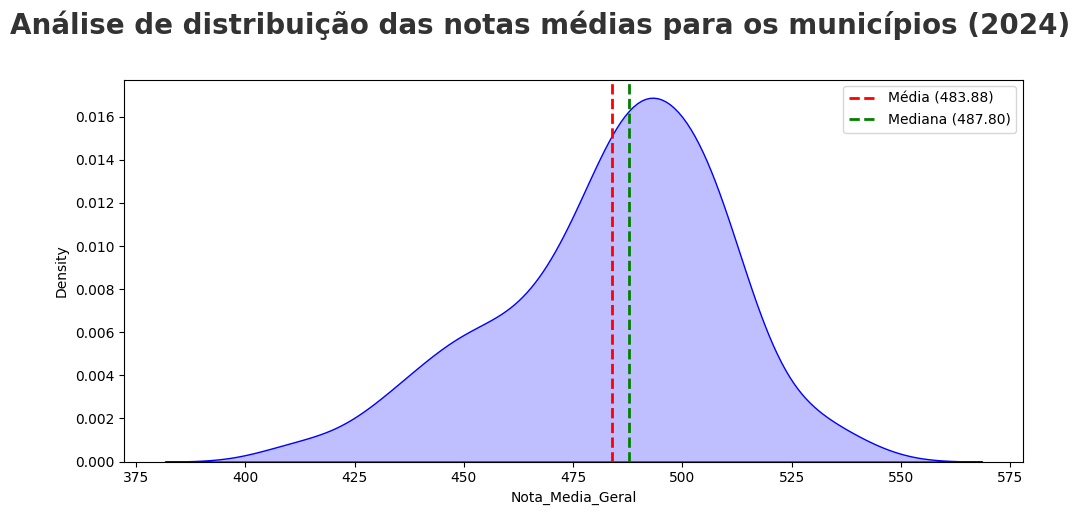

Média: 483.88424608433127
Mediana: 487.7991937903808
Skew: -0.5765810344634975


In [23]:
plt.figure(figsize=(10, 5))
plt.suptitle(
    "Análise de distribuição das notas médias para os municípios (2024)",
    fontsize=20,
    fontweight='bold',
    alpha=0.8,
    y=1.02
)

# KDE plot
sns.kdeplot(
    data=df_indicadores_mun,
    x='Nota_Media_Geral',
    fill=True,
    color='blue'
)

# Calculando média e mediana
media = df_indicadores_mun['Nota_Media_Geral'].mean()
mediana = df_indicadores_mun['Nota_Media_Geral'].median()
skew = df_indicadores_mun['Nota_Media_Geral'].skew()

# Linhas verticais
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média ({media:.2f})")
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f"Mediana ({mediana:.2f})")

# Legenda
plt.legend()

plt.tight_layout()
plt.show()

print(f"Média: {media}")
print(f"Mediana: {mediana}")
print(f"Skew: {skew}")

> A nota média se concentra entre 490 e 500

### Análise Univariada da gestão digital

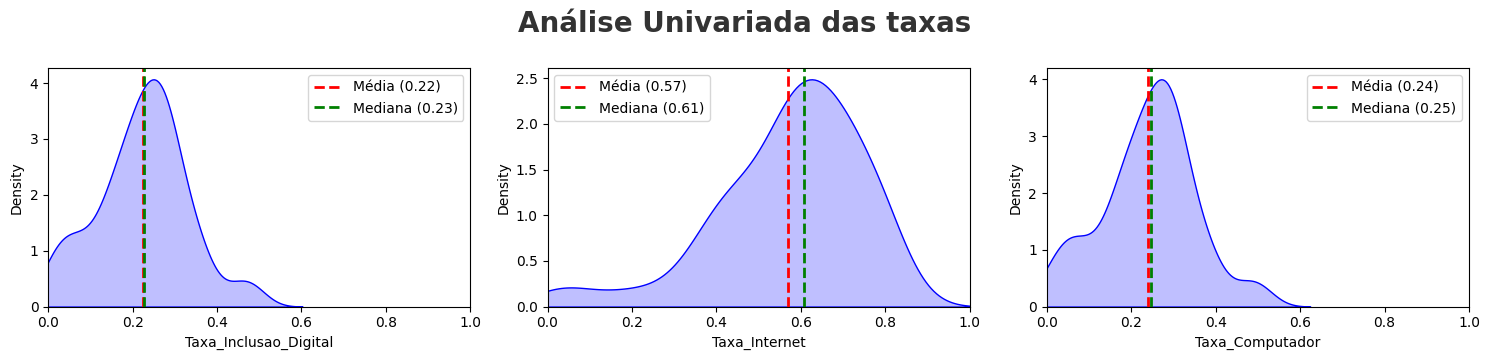

In [24]:
plt.figure(figsize=(15, 15))
plt.suptitle("Análise Univariada das taxas", fontsize=20, fontweight='bold', alpha=0.8, y=1.0)

numeric_features = ['Taxa_Inclusao_Digital', 'Taxa_Internet', 'Taxa_Computador']

for i in range(len(numeric_features)):
    # 1. PRIMEIRO ative o subplot correto
    plt.subplot(5, 3, i+1)
    
    # 2. Desenhe o gráfico principal (KDE)
    sns.kdeplot(data=df_indicadores_mun, x=numeric_features[i], fill=True, color='blue')
    
    # 3. Calcule as estatísticas
    media = df_indicadores_mun[numeric_features[i]].mean()
    mediana = df_indicadores_mun[numeric_features[i]].median()
    
    # 4. AGORA desenhe as linhas (elas vão aparecer no subplot ativo acima)
    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média ({media:.2f})")
    plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f"Mediana ({mediana:.2f})")
    
    # Configurações adicionais
    plt.xlabel(numeric_features[i])
    plt.xlim(0, 1)
    plt.legend() # Adicionei para mostrar as labels da média/mediana

plt.tight_layout()
plt.show()

> A distribuição de probabilidade aponta para um cenário ruim tanto na taxa de inclusão digital quanto na taxa_computador. O que significa dizer que existe um inclusão digital "parcial", mais voltada à conectividade do que a dispositivos. O que no cenário educacional prejudica mais os alunos, pois ter internet sem um dispositivo adequado não ajuda no desempenho dos mesmos.

> A taxa de inclusão digital tem uma média entre 26% apenas entre os municípios

## Análise Bivariada

### Matriz de Correlação

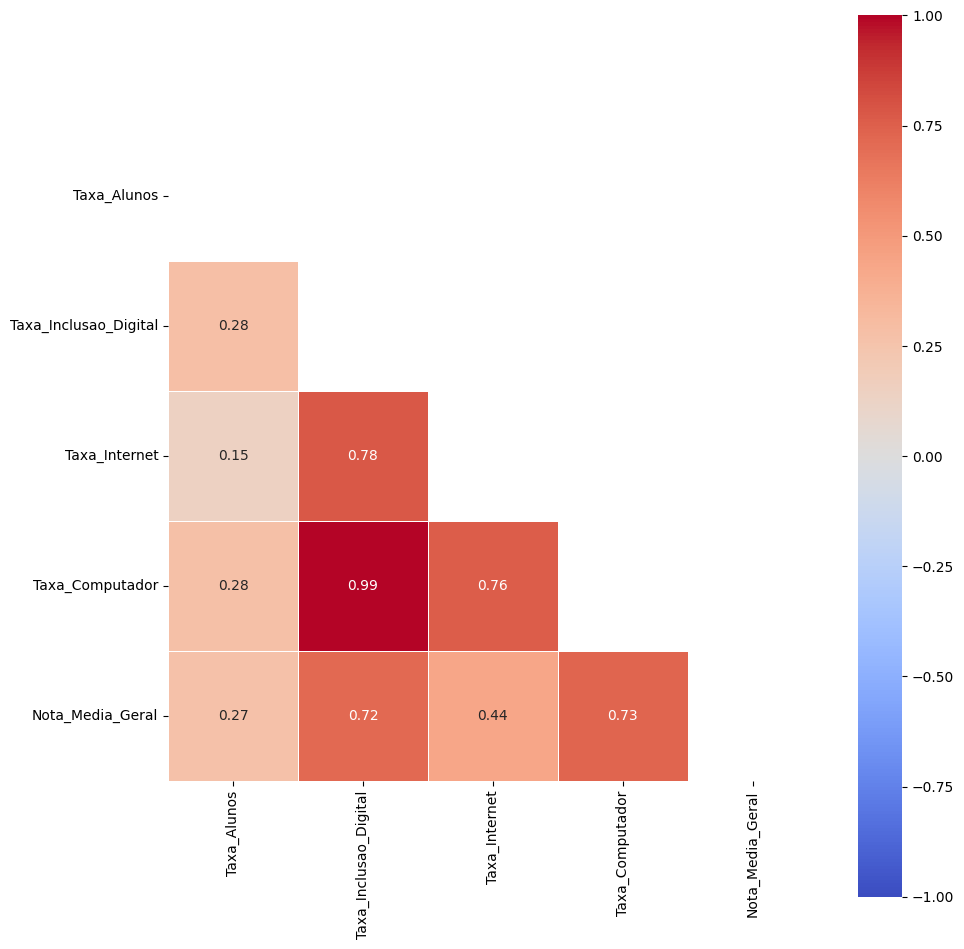

In [25]:
correlations = df_indicadores_mun[['Taxa_Alunos','Taxa_Inclusao_Digital','Taxa_Internet', 'Taxa_Computador', 'Nota_Media_Geral']].corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(correlations, 
            annot=True,
            mask=mask,
            cmap='coolwarm',  
            square=True, 
            linewidths=.5, 
            cbar=True, 
            vmin=-1, 
            vmax=1)

plt.tight_layout()

# Mostre o heatmap
plt.show()

> A "Inclusão Digital" não é travada pela falta de cabos ou conectividade, mas sim pela falta do dispositivos. A política pública deveria focar em hardware, pois a conectividade já parece acompanhar quem tem o hardware. Basicamente, acesso a internet sem o dispotivo adequado (um celular não é o suficiente) não ajuda tanto assim.

# 2024

### Analise de distribuição da nota média

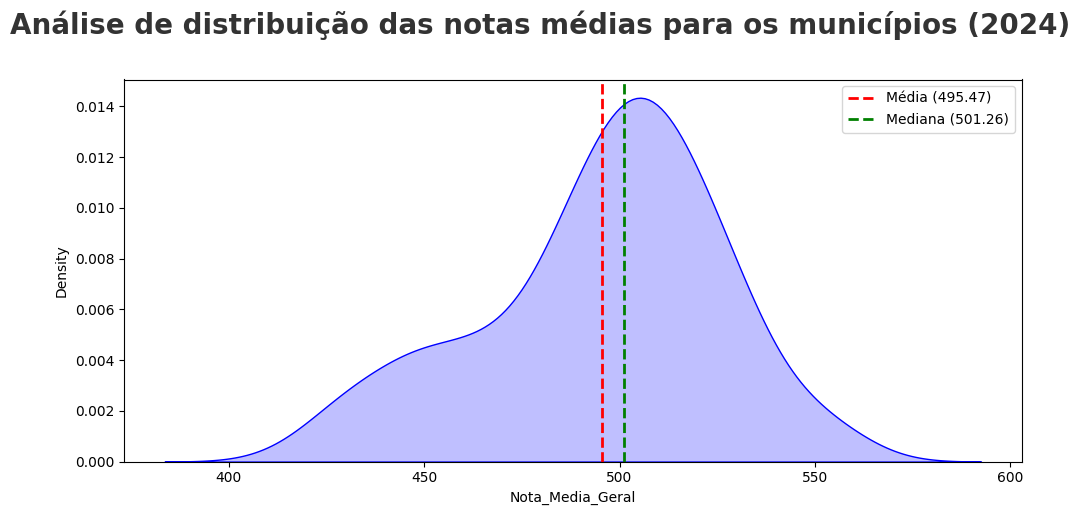

Média: 495.46615486128024
Mediana: 501.25681381381384


In [27]:
plt.figure(figsize=(10, 5))
plt.suptitle(
    "Análise de distribuição das notas médias para os municípios (2024)",
    fontsize=20,
    fontweight='bold',
    alpha=0.8,
    y=1.02
)

# KDE plot
sns.kdeplot(
    data=df_indicadores_mun23,
    x='Nota_Media_Geral',
    fill=True,
    color='blue'
)

# Calculando média e mediana
media = df_indicadores_mun23['Nota_Media_Geral'].mean()
mediana = df_indicadores_mun23['Nota_Media_Geral'].median()

# Linhas verticais
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média ({media:.2f})")
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f"Mediana ({mediana:.2f})")

# Legenda
plt.legend()

plt.tight_layout()
plt.show()

print(f"Média: {media}")
print(f"Mediana: {mediana}")


### Análise de distribuição das taxas

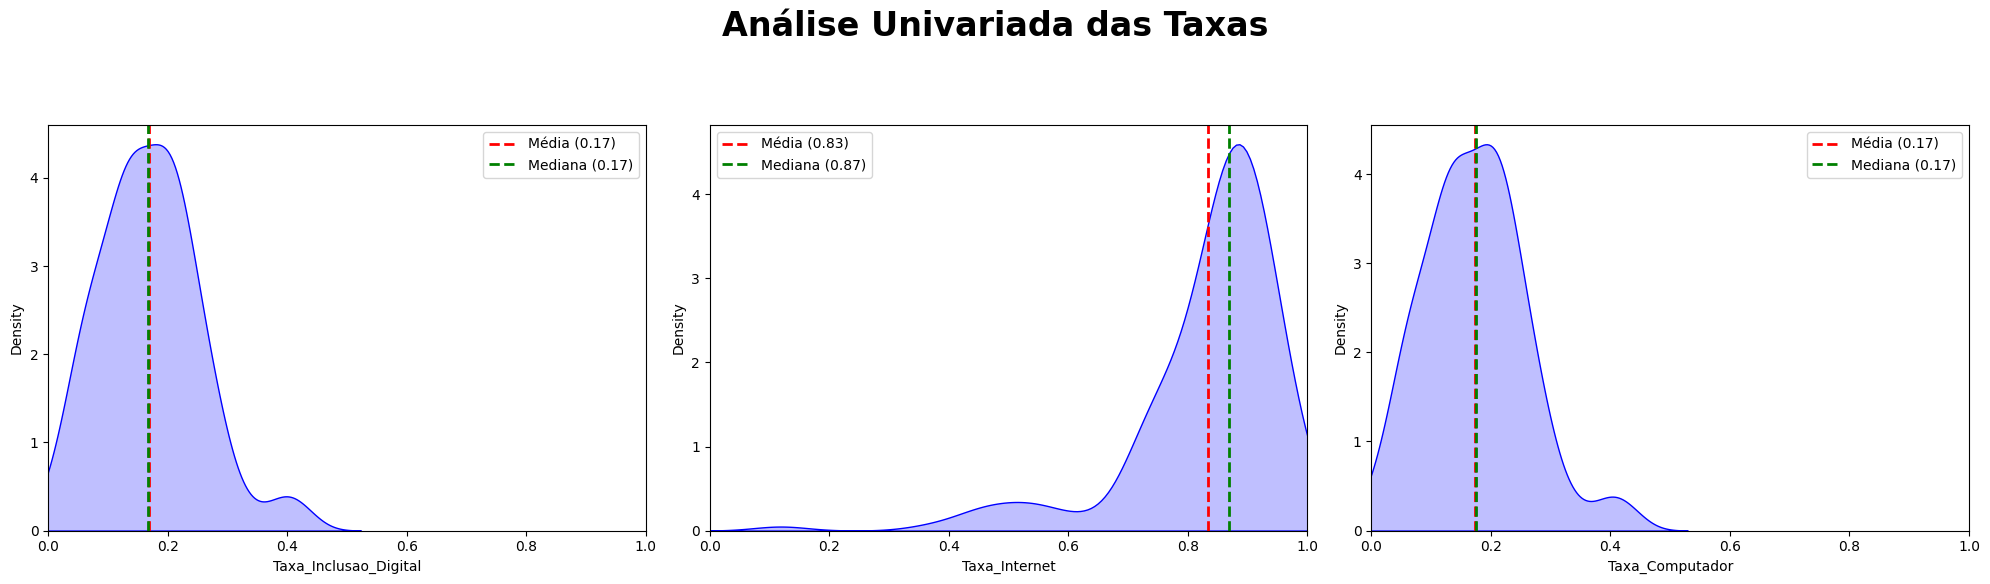

In [28]:
plt.figure(figsize=(20, 26))

# Título central ajustado para não colidir com os subplots
plt.suptitle(
    "Análise Univariada das Taxas",
    fontsize=24,
    fontweight='bold',
    y=0.92   # <-- posição mais alta, acima dos gráficos
)

numeric_features = ['Taxa_Inclusao_Digital', 'Taxa_Internet', 'Taxa_Computador']

for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i+1)

    # KDE
    sns.kdeplot(
        data=df_indicadores_mun23,
        x=feature,
        fill=True,
        color='blue'
    )

    # Média e mediana
    media = df_indicadores_mun23[feature].mean()
    mediana = df_indicadores_mun23[feature].median()

    plt.axvline(media, color='red', linestyle='--', linewidth=2,
                label=f"Média ({media:.2f})")
    plt.axvline(mediana, color='green', linestyle='--', linewidth=2,
                label=f"Mediana ({mediana:.2f})")

    plt.xlabel(feature)
    plt.xlim(0, 1)
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # <-- reserva espaço p/ o título

plt.show()


In [ ]:
df_indicadores_mun.sort_values(by=['Taxa_Inclusao_Digital'], ascending=False)

,NO_MUNICIPIO_PROVA,Total_Alunos,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Taxa_Alunos
39,Fortaleza,71173,34669,0.487109,56844,0.798674,35946,0.505051,614.834558,523.902734,543.529739,533.426242,489.605600,541.059775,0.321607
63,Juazeiro do Norte,8203,3918,0.477630,6538,0.797025,4134,0.503962,612.614897,505.058771,529.524235,520.468536,477.388358,529.010959,0.037067
34,Crato,3592,1710,0.476058,2839,0.790367,1793,0.499165,613.814031,508.147049,525.353814,520.734243,479.897272,529.589282,0.016231
13,Barbalha,1840,848,0.460870,1429,0.776630,887,0.482065,591.141304,496.852391,516.506848,512.565054,474.058315,518.224783,0.008314
107,Tabuleiro do Norte,980,428,0.436735,785,0.801020,446,0.455102,578.714286,493.141327,514.344592,509.829082,469.243980,513.054653,0.004428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Pacoti,930,125,0.134409,364,0.391398,150,0.161290,534.086022,477.396667,476.996237,495.092258,440.481613,484.810559,0.004202
114,Uruburetama,1259,154,0.122319,352,0.279587,195,0.154885,511.119936,472.365766,486.074424,490.459095,445.280620,481.059968,0.005689
88,Paraipaba,1040,124,0.119231,290,0.278846,143,0.137500,534.134615,481.023942,507.023654,496.227308,454.955769,494.673058,0.004699
110,Tejuçuoca,508,48,0.094488,193,0.379921,53,0.104331,511.338583,468.959252,493.403346,485.488189,437.283661,479.294606,0.002295


In [29]:
df_indicadores_mun23.sort_values(by=['Taxa_Inclusao_Digital'], ascending=False)

,MUNICIPIO,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Total_Alunos,Taxa_Alunos
0,Fortaleza,652.884172,537.033357,559.518961,530.382698,507.469060,560.222569,32283,0.434063,66281,0.891185,32646,0.438944,74374,0.306797
1,Eusébio,638.696343,525.409459,547.209304,523.016693,493.617016,550.103269,780,0.420032,1790,0.963920,788,0.424340,1857,0.007660
2,Juazeiro do Norte,657.386505,526.989844,547.848146,521.031420,500.777275,553.422521,4033,0.405286,9068,0.911265,4088,0.410813,9951,0.041048
3,Limoeiro do Norte,673.108808,525.486917,550.956789,521.789184,498.480334,556.859531,811,0.398526,1881,0.924324,822,0.403931,2035,0.008394
4,Sobral,653.237485,523.077377,557.019438,516.119470,496.983512,552.325793,2953,0.388604,7023,0.924201,2976,0.391630,7599,0.031346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Catunda,449.577465,444.388732,440.726087,449.971831,417.565217,441.373333,2,0.021739,86,0.934783,2,0.021739,92,0.000380
180,Miraíma,421.257143,437.051429,436.858824,447.128571,416.631176,434.467219,3,0.015075,195,0.979899,3,0.015075,199,0.000821
181,Arneiroz,408.955224,461.120896,462.463492,458.667164,447.988889,452.694194,1,0.010870,77,0.836957,1,0.010870,92,0.000380
182,Catarina,360.923077,430.516923,462.696825,445.923077,426.971429,430.420645,0,0.000000,100,1.000000,0,0.000000,100,0.000413


#### Correlação mudando

- "Em 2019, o 'Filtro Social' barrava o aluno na conexão (Internet). Quem passava pela barreira da internet, tinha chance.

- Em 2024, o filtro mudou de lugar. A porteira da internet foi aberta (correlação baixa), mas uma nova barreira, mais alta e rígida, foi erguida: a do Hardware (Computador).

Nossa métrica de Inclusão Digital Plena é robusta porque ela identifica exatamente quem conseguiu pular esse novo muro. Ela limpa o ruído do 'falso incluído' (o aluno que só tem celular) e foca no aluno que realmente tem estrutura de estudo."

In [30]:
print("2019")
display(df_indicadores_mun[['Taxa_Computador', 'Nota_Media_Geral']].corr())
display(df_indicadores_mun[['Taxa_Internet', 'Nota_Media_Geral']].corr())
print("\n")
print("2024")
display(df_indicadores_mun23[['Taxa_Computador', 'Nota_Media_Geral']].corr())
display(df_indicadores_mun23[['Taxa_Internet', 'Nota_Media_Geral']].corr())


2019


,Taxa_Computador,Nota_Media_Geral
Taxa_Computador,1.000000,0.731715
Nota_Media_Geral,0.731715,1.000000


,Taxa_Internet,Nota_Media_Geral
Taxa_Internet,1.000000,0.437169
Nota_Media_Geral,0.437169,1.000000




2024


,Taxa_Computador,Nota_Media_Geral
Taxa_Computador,1.000000,0.807865
Nota_Media_Geral,0.807865,1.000000


,Taxa_Internet,Nota_Media_Geral
Taxa_Internet,1.000000,0.157791
Nota_Media_Geral,0.157791,1.000000


#### Municípios que precisam de ajuda

In [36]:
p25 = np.percentile(df_indicadores_mun23['Taxa_Inclusao_Digital'], 25)
df24_sos = df_indicadores_mun23[df_indicadores_mun23['Taxa_Inclusao_Digital'] <= p25]
df24_sos

,MUNICIPIO,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Total_Alunos,Taxa_Alunos
138,Paraipaba,571.884058,494.058213,509.785316,488.898551,470.130340,507.695665,111,0.108824,453,0.444118,114,0.111765,1020,0.004208
139,Ibicuitinga,456.666667,455.032051,456.152703,468.544872,446.537838,461.605135,11,0.106796,98,0.951456,11,0.106796,103,0.000425
140,Moraújo,572.602740,490.723288,513.695652,482.058904,453.430435,506.515652,9,0.104651,72,0.837209,9,0.104651,86,0.000355
141,Beberibe,584.916512,487.887106,491.538013,491.213451,461.533333,505.141797,130,0.102524,897,0.707413,137,0.108044,1268,0.005231
142,Ibaretama,407.968750,445.349219,434.686719,443.914844,427.475781,431.879062,13,0.100775,119,0.922481,13,0.100775,129,0.000532
143,Itatira,610.187970,456.068421,466.489714,457.046992,439.306476,488.635231,65,0.100309,516,0.796296,66,0.101852,648,0.002673
144,Graça,421.495327,465.195327,459.581308,448.180374,431.386916,445.859057,12,0.100000,106,0.883333,12,0.100000,120,0.000495
145,Mulungu,579.855072,479.584420,467.559630,475.838043,448.192593,493.578561,36,0.099448,206,0.569061,40,0.110497,362,0.001493
146,Tururu,470.240964,443.374096,434.522561,459.638554,430.451220,448.361220,19,0.097938,102,0.525773,20,0.103093,194,0.000800
147,Fortim,446.769231,442.952308,461.660294,462.427692,442.210294,450.900312,15,0.090361,106,0.638554,15,0.090361,166,0.000685


#### Relação entre variação da taxa e variação de alunos

In [34]:
df_merge = pd.merge(df_indicadores_mun, df_indicadores_mun23, how='left' ,
                    on='MUNICIPIO',
                    suffixes=('_19', '_24'))


C:\Users\139595\AppData\Local\Temp\ipykernel_8704\94062102.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])


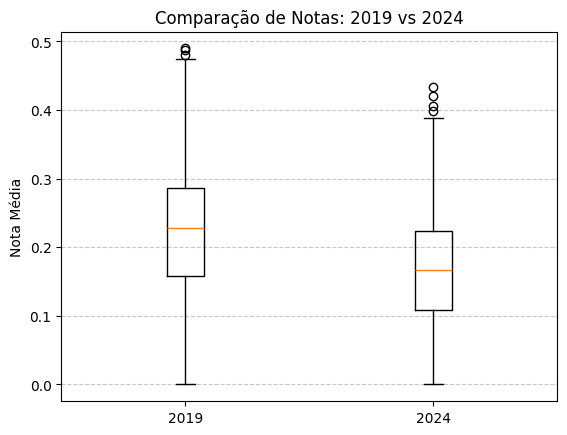

C:\Users\139595\AppData\Local\Temp\ipykernel_8704\94062102.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])


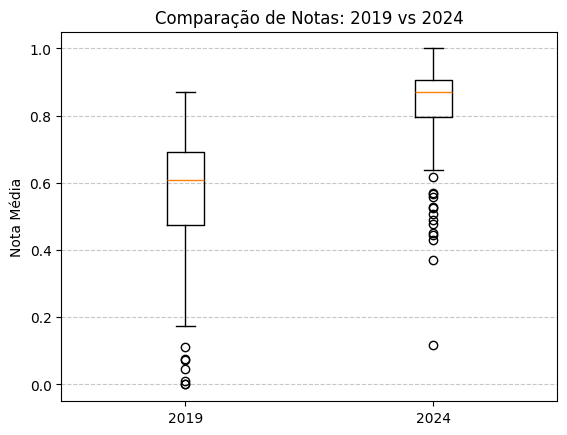

C:\Users\139595\AppData\Local\Temp\ipykernel_8704\94062102.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])


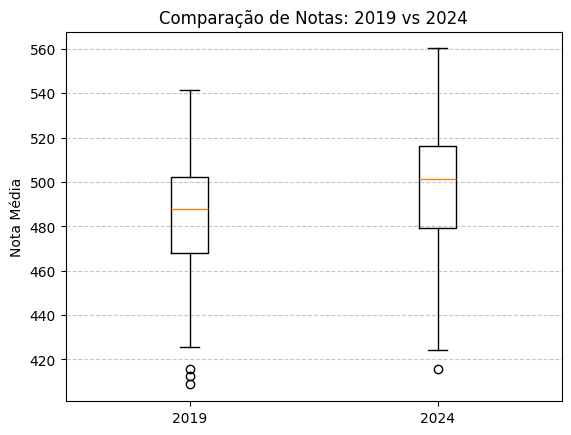

In [35]:

for i in ['Taxa_Inclusao_Digital','Taxa_Internet', 'Nota_Media_Geral']:
  # Seus dados
  data_group1 = df_indicadores_mun[i]
  # Nota: Para boxplot, os grupos NÃO precisam ter o mesmo tamanho.
  # Você não precisa cortar o group2 para ficar igual ao group1 se não quiser.
  data_group2 = df_indicadores_mun23[i]

  # CORREÇÃO: Coloque-os dentro de uma lista [a, b]
  data = [data_group1, data_group2]

  # Agora vai funcionar
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])
  plt.title('Comparação de Notas: 2019 vs 2024')
  plt.ylabel('Nota Média')
  plt.grid(True, axis='y', linestyle='--', alpha=0.7) # Dica extra: fica mais fácil de ler
  plt.show()

# Hipótese IA Generativa e Redação
Queremos propor a hipótese de que houve uma melhora no desempenho dos alunos em redação por conta da chegada da IA generativa, dado que esta é nativamente linguística. Com isso, aliado à conectividade facilitaria ainda mais o desempenho dos alunos, independente do dispositivo utilizado, o que poderia explicar parte da melhora das notas, apesar da queda da inclusão digital, alavancada pela falta de dispositivos como computadores e notebook

- Elaborar gráfico comparando as taxas analisadas num gráfico de barras
- Elaborar gráfico comparando as variações percentuais de um ano pra outro das notas do ENEM, e checar se redação possui um aumento maior

In [ ]:
def grafico_comparativo(df_indicadores_mun, df_indicadores_mun24, notas = False):
  df_final = pd.merge(
    df_indicadores_mun[['NO_MUNICIPIO_RESIDENCIA', 'Taxa_Inclusao_Digital', 'Taxa_Computador', 'Taxa_Internet', 'Nota_Media_Geral', 'Nota_Redacao','Nota_CH', 'Nota_Mat', 'Nota_CN', 'Nota_LC', 'Total_Alunos']],
    df_indicadores_mun24[['NO_MUNICIPIO_PROVA', 'Taxa_Inclusao_Digital', 'Taxa_Computador', 'Taxa_Internet', 'Nota_Media_Geral', 'Nota_Redacao','Nota_CH', 'Nota_Mat', 'Nota_CN', 'Nota_LC','Total_Alunos']],
    right_on='NO_MUNICIPIO_PROVA',
    left_on='NO_MUNICIPIO_RESIDENCIA',
    suffixes=('_2019', '_2024'))
  
  # condicionar flag notas
  if notas:
    metricas = {
    'Nota_Media_Geral': 'Nota Média',
    'Nota_Redacao': 'Nota Redação',
    'Nota_CH': 'Nota CH',
    'Nota_LC': 'Nota LC',
    'Nota_CN': 'Nota CN',
    'Nota_Mat': 'Nota Mat',

    }
    
  else:
    metricas = {
    'Taxa_Inclusao_Digital': 'Taxa Inclusão Digital',
    'Taxa_Computador': 'Taxa Computador',
    'Taxa_Internet': 'Taxa Internet',
    'Total_Alunos': 'Total de Alunos (Média Mun.)'}


  dados_resumo = []
  # criar tabela de resumo
  for metrica_db, metrica_nome in metricas.items():
      valor_19 = df_final[f'{metrica_db}_2019'].mean()
      valor_24 = df_final[f'{metrica_db}_2024'].mean()
      
      if metrica_db == 'Total_Alunos':
          valor_19 = df_final[f'{metrica_db}_2019'].sum()
          valor_24 = df_final[f'{metrica_db}_2024'].sum()
          metrica_nome = 'Total de Alunos (Soma Estado)'
      
      delta = valor_24 - valor_19
      var_pct = (delta / valor_19) * 100
      
      dados_resumo.append({
          'Indicador': metrica_nome,
          '2019': valor_19,
          '2024': valor_24,
          'Diferença': delta,
          'Variação (%)': var_pct
      })

  df_resumo_executivo = pd.DataFrame(dados_resumo)

  display(df_resumo_executivo) 

  # gerar gráfico
  df_plot = df_resumo_executivo[df_resumo_executivo['Indicador'] != 'Total de Alunos (Soma Estado)'].melt(
      id_vars='Indicador', 
      value_vars=['2019', '2024'], 
      var_name='Ano', 
      value_name='Valor'
  )

  plt.figure(figsize=(14, 9))
  grafico = sns.barplot(data=df_plot, x='Indicador', y='Valor', hue='Ano', palette=['gray', 'blue'])

  plt.title('Comparativo de Indicadores: 2019 vs 2024', fontsize=14)
  plt.ylabel('Taxa Média / Nota')
  plt.xticks(rotation=15)
  plt.legend(title='Ano')


  for container in grafico.containers:
      grafico.bar_label(container, fmt='%.2f', padding=3)

  plt.tight_layout()
  plt.show()


,Indicador,2019,2024,Diferença,Variação (%)
0,Taxa Inclusão Digital,0.264431,0.214464,-0.049968,-18.896266
1,Taxa Computador,0.283944,0.219900,-0.064044,-22.555149
2,Taxa Internet,0.601356,0.801192,0.199836,33.230813
3,Total de Alunos (Soma Estado),205062.000000,250607.000000,45545.000000,22.210356


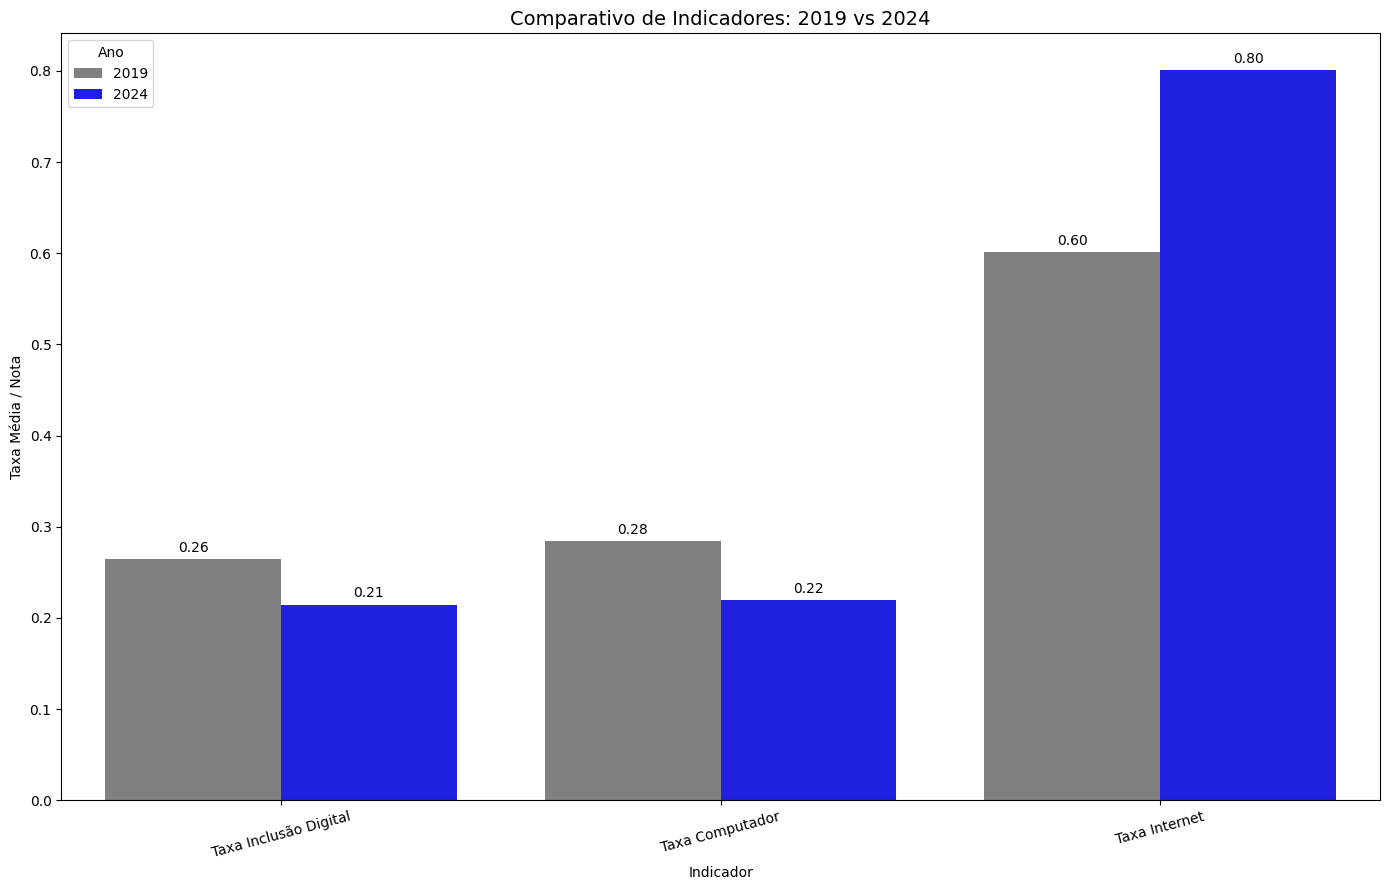

,Indicador,2019,2024,Diferença,Variação (%)
0,Nota Média,497.284015,513.742498,16.458483,3.309675
1,Nota Redação,545.596906,601.706399,56.109492,10.284056
2,Nota CH,484.512138,485.208357,0.696219,0.143695
3,Nota LC,500.407617,502.731409,2.323793,0.464380
4,Nota CN,454.359160,469.293367,14.934207,3.286873
5,Nota Mat,501.544255,509.772958,8.228703,1.640673


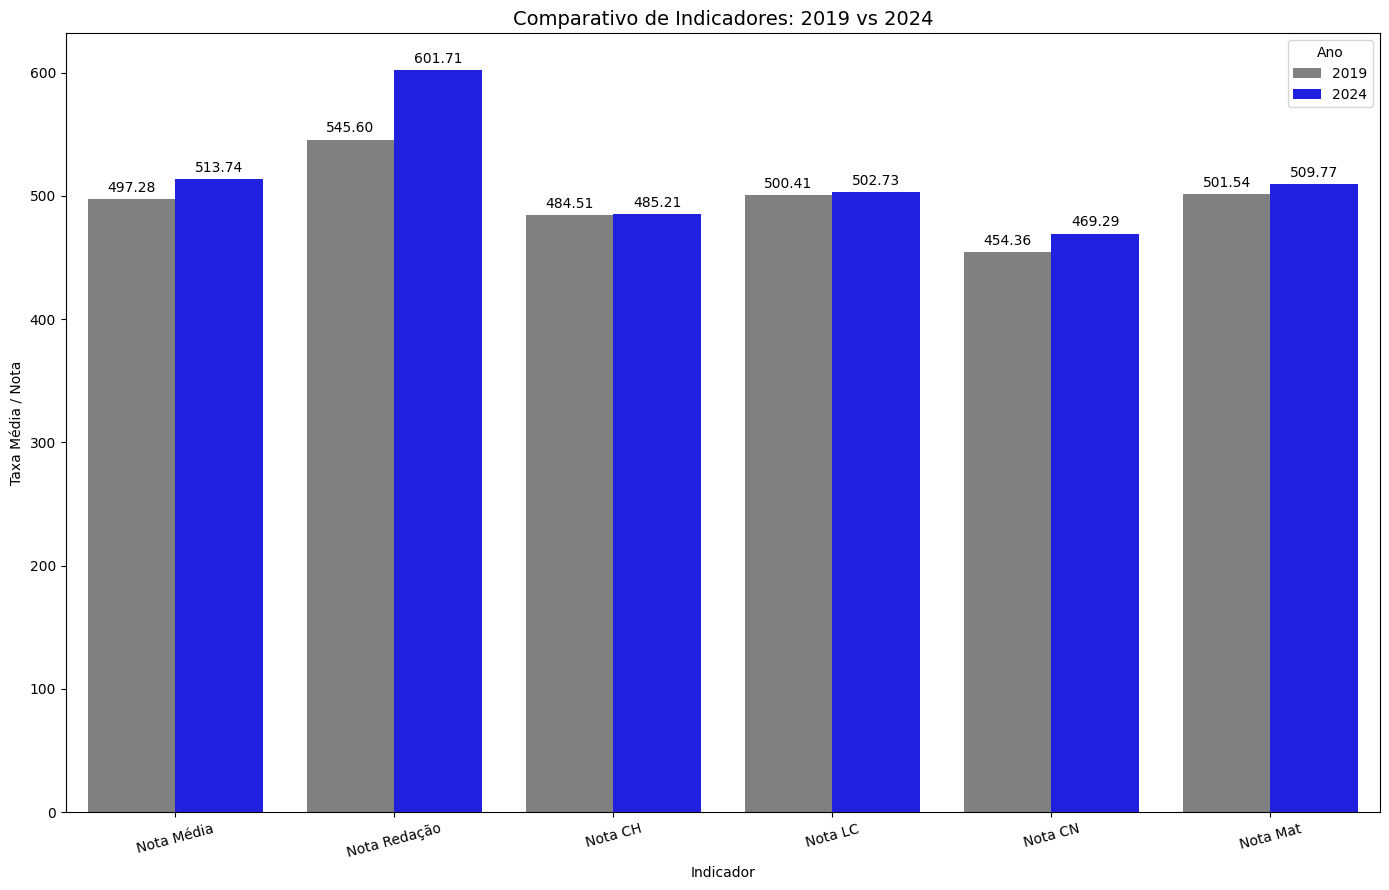

In [ ]:
grafico_comparativo(df_indicadores_mun=df_indicadores_mun, df_indicadores_mun24=df_indicadores_mun24, notas = 0)
print("\n\n\n\n")
grafico_comparativo(df_indicadores_mun=df_indicadores_mun, df_indicadores_mun24=df_indicadores_mun24, notas = 1)


## Salvar dados

In [39]:
df_indicadores_mun23.rename(columns={'MUNICIPIO': 'NO_MUNICIPIO_PROVA'}, inplace=True)

In [40]:
# df_indicadores_mun.to_csv('indicadores19.csv')
df_indicadores_mun23.to_csv('indicadores23.csv')

# Causal Inference

O Problema: A simples diferença de médias diz que quem tem internet tira X pontos a mais. Isso é verdade ou é apenas reflexo da riqueza?

A Metodologia: Usamos Inferência Causal para simular o contrafactual (O aluno com internet, caso não a tivesse).

O Resultado (ATT): "Corrigindo pelo viés socioeconômico, a internet agrega X pontos na média."

O Insight (CATE): "Entretanto, para alunos de baixa renda, a internet tem um impacto Y% maior do que para alunos de alta renda."

In [ ]:
colunas_interesse = [
    'NU_INSCRICAO', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'SG_UF_RESIDENCIA', 
    'TP_ESCOLA', 'IN_TREINEIRO',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 
    'TP_STATUS_REDACAO',
    'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'SG_UF_PROVA', 'NO_MUNICIPIO_PROVA'
]

In [ ]:
df = df_raw[colunas_interesse]

In [ ]:
df = df[
  (df['SG_UF_RESIDENCIA'] == 'CE') & (df['NO_MUNICIPIO_PROVA'] != 'Fortaleza')
   ]

In [ ]:
df['NU_NOTA_GERAL'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT'] + df['NU_NOTA_REDACAO']) / 5


In [ ]:
df['Computador e Internet'] = np.where(
  (df['Q025'] == 'B') & (df['Q024'] != "A"),1, 0
)

In [ ]:
df['Computador'] = np.where(
  (df['Q025'] == 'B'),1, 0
)

In [ ]:
df['Computador'].value_counts(normalize=True)

Computador
1    0.620751
0    0.379249
Name: proportion, dtype: float64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(df['Q001'])
df['Q001_encoded'] = le.transform(df['Q001'])
# Criar uma nova coluna chamada 'Q006_encoded' no DataFrame df
le.fit(df['Q006'])
df['Q006_encoded'] = le.transform(df['Q006'])


In [ ]:
# Lista de variáveis a serem convertidas
confundidores = [
    'Q006', 'Q001', 'Q002', 'TP_ESCOLA', 'TP_COR_RACA', 
    'NU_IDADE', 'SG_UF_RESIDENCIA'
]

# Converter cada variável para numérica (exceto NU_IDADE que já é numérica)
for coluna in confundidores:
    if coluna in df.columns:
        if coluna != 'NU_IDADE':  # Pula a coluna de idade
            df[coluna] = pd.factorize(df[coluna])[0]  # Converte categorias em códigos numéricos
    else:
        print(f"Aviso: Coluna '{coluna}' não encontrada no DataFrame.")

# Verificar os tipos de dados resultantes
df

,NU_INSCRICAO,NU_IDADE,TP_SEXO,TP_COR_RACA,SG_UF_RESIDENCIA,TP_ESCOLA,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,...,Q006,Q024,Q025,SG_UF_PROVA,NO_MUNICIPIO_PROVA,NU_NOTA_GERAL,Computador e Internet,Computador,Q001_encoded,Q006_encoded
73,190001133213,26.0,M,0,0,0,0,0,0,0,...,0,B,B,CE,Juazeiro do Norte,NaN,1,1,4,3
90,190001133215,23.0,M,0,0,1,0,0,0,0,...,1,A,A,CE,Juazeiro do Norte,NaN,0,0,1,0
126,190001133216,24.0,F,1,0,1,0,0,0,0,...,0,B,B,CE,Quixeramobim,NaN,1,1,0,3
193,190001133218,21.0,F,2,0,1,0,1,1,1,...,2,A,B,CE,Eusébio,583.82,0,1,1,1
195,190001133220,22.0,M,2,0,1,0,0,0,0,...,2,B,B,CE,Tauá,NaN,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095133,190005703237,35.0,M,0,0,1,0,1,1,1,...,6,B,B,CE,Crateús,646.72,1,1,1,7
5095136,190005703238,18.0,M,4,0,0,0,0,0,0,...,2,A,A,CE,Juazeiro do Norte,NaN,0,0,7,1
5095179,190005703239,33.0,M,1,0,1,0,1,1,1,...,3,B,B,CE,Quixeramobim,443.48,1,1,0,2
5095217,190005701188,19.0,M,0,0,1,0,0,0,0,...,3,B,B,CE,Barreira,NaN,1,1,6,2


In [ ]:
# Definindo os limites (ex: 5% e 95%)
min_ps = 0.05
max_ps = 0.87



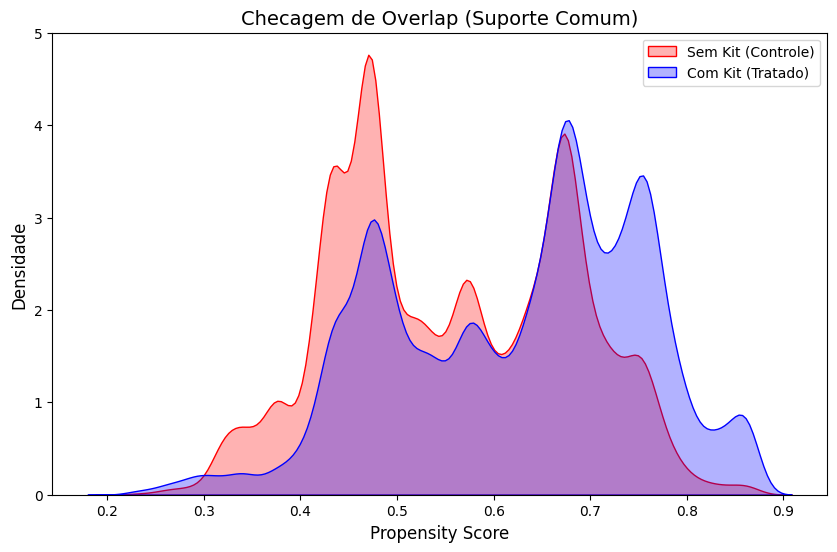

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Defina seus Confundidores (X) e Tratamento (T)
# Adicione aqui todas as variáveis que causam T e Y (ex: Renda, Escolaridade Mãe, Tipo Escola, Raça)
# IMPORTANTE: As variáveis categóricas devem estar codificadas (Get Dummies ou LabelEncoder)
# confundidores = ['Q006_encoded', 'Q001_encoded', 'TP_ESCOLA', 'NU_NOTA_CH', 'NU_NOTA_LC'] # Exemplo
X = df[confundidores].fillna(0) # Trate nulos antes
T = df['Computador'] # Sua variável binária criada

# 2. Calcule o Propensity Score
# Usamos Logistic Regression para estimar P(T=1 | X)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X, T)
ps_score = clf.predict_proba(X)[:, 1] # Pega a prob da classe 1

# Adiciona ao dataframe para plotar
df['ps_score'] = ps_score

# Filtrando o dataframe (Trimming)
df_trim = df[
    (df['ps_score'] >= min_ps) & 
    (df['ps_score'] <= max_ps)
]

# 3. Plote o Gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_trim[df_trim['Computador'] == 0], x='ps_score', fill=True, label='Sem Kit (Controle)', color='red', alpha=0.3)
sns.kdeplot(data=df_trim[df_trim['Computador'] == 1], x='ps_score', fill=True, label='Com Kit (Tratado)', color='blue', alpha=0.3)

plt.title('Checagem de Overlap (Suporte Comum)', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.show()

In [ ]:

# Supondo que seu dataframe seja 'df' e já tenha as colunas:
# 'ps_score': o score que você gerou no gráfico
# 'Computador e Internet': seu T (0 ou 1)
# 'NU_NOTA_GERAL': sua variável Y (média das notas, ou a nota que vc quer analisar)

# 1. Definir limites de Trimming (Segurança Estatística)
# Vamos manter apenas alunos onde há disputa real entre ter e não ter o kit
min_score = 0.05
max_score = 0.95

mask_overlap = (df['ps_score'] >= min_score) & (df['ps_score'] <= max_score)
df_trimmed = df[mask_overlap].copy()

print(f"Linhas originais: {len(df)}")
print(f"Linhas após trimming: {len(df_trimmed)} (Perda segura para garantir robustez)")

# 2. Calcular os Pesos (Weights) para ATT
# Para quem TEM computador (T=1), o peso é 1.
# Para quem NÃO TEM (T=0), o peso é odds = PS / (1 - PS).
# Isso faz os "sem computador" que parecem ricos valerem por muitos.

df_trimmed['w_att'] = np.where(
    df_trimmed['Computador e Internet'] == 1,
    1,
    df_trimmed['ps_score'] / (1 - df_trimmed['ps_score'])
)

# 3. Calcular o Efeito Causal (Diferença de Médias Ponderada)
# Y1: Média ponderada dos Tratados
y1_w = np.average(df_trimmed.loc[df_trimmed['Computador e Internet']==1, 'NU_NOTA_GERAL'],
                  weights=df_trimmed.loc[df_trimmed['Computador e Internet']==1, 'w_att'])

# Y0: Média ponderada dos Controles (O Contrafactual!)
y0_w = np.average(df_trimmed.loc[df_trimmed['Computador e Internet']==0, 'NU_NOTA_GERAL'],
                  weights=df_trimmed.loc[df_trimmed['Computador e Internet']==0, 'w_att'])

att = y1_w - y0_w

# 4. Comparação "Naïve" (Ingênua - sem causalidade)
naive_diff = df_trimmed[df_trimmed['Computador e Internet']==1]['NU_NOTA_GERAL'].mean() - \
             df_trimmed[df_trimmed['Computador e Internet']==0]['NU_NOTA_GERAL'].mean()

print(f"\n--- RESULTADOS ---")
print(f"Diferença 'Ingênua' (Média simples): {naive_diff:.2f} pontos")
# print(f"ATT Estimado (Efeito Causal Real):   {att:.2f} pontos")
# print(f"Viés de Seleção removido:            {naive_diff - att:.2f} pontos")
print(y1_w)

Linhas originais: 201008
Linhas após trimming: 195843 (Perda segura para garantir robustez)

--- RESULTADOS ---
Diferença 'Ingênua' (Média simples): 52.53 pontos
nan
